# Letter Detection
Letter detection model based in the [hand written data set](https://www.kaggle.com/datasets/sachinpatel21/az-handwritten-alphabets-in-csv-format).

## Data Instatiation

In [1]:
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
import pandas as pd
from matplotlib import pyplot as plt
import os

In [2]:
# df = pd.read_csv('./data/A_Z_original.csv');
# df.sample(frac=0.1).to_csv('./data/A_Z_0.1.csv', index=False);
df = pd.read_csv('./data/A_Z_0.1.csv', index_col=False);

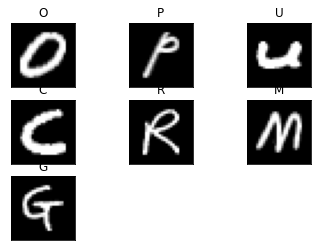

In [3]:
import numpy as np
import random
import math

IMAGE_SIZE= 28*28;

def plotImg(array, letter):
    matrix = np.array(array)[0][1:]
    matrix = matrix.reshape((28,28))
    
    plt.title(letter.upper())
    plt.xticks([])
    plt.yticks([])
    plt.imshow(matrix, cmap=plt.get_cmap('gray'))
    
def plotSingleImg(array, letter):
    fig = plt.figure()
    fig.patch.set_facecolor('xkcd:white')
    plotImg(array, letter)
    plt.show();
    
def plotRandonLetters(df, n):
    letters = [0 for i in range(26)]
    fig = plt.figure()
    fig.patch.set_facecolor('xkcd:white')
    rows = math.ceil(n ** (1/2))
    cols = rows
    
    for i in range(n):
        while True:
            sample = df.sample(1)
            if letters[sample.iloc[0][0]] == 0:
                letters[sample.iloc[0][0]] = 1
                fig.add_subplot(rows, cols, i + 1)
                
                plotImg(sample, chr(sample.iloc[0][0] + ord('a')))
                break;

    plt.show();

plotRandonLetters(df, 7)

In [4]:
X = df.iloc[:,1:]
y = df.iloc[:,0]
y = keras.utils.to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

## Model Creation

In [5]:
MODEL_NAME = '256_256_64__1'
MODEL_DIR = './Models/{}'.format(MODEL_NAME)
MODEL_PATH = '{}/{}'.format(MODEL_DIR, MODEL_NAME)
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
    
model = keras.Sequential([
    # L1
    layers.Dense(units=256, input_shape=[IMAGE_SIZE]),
    # L2
    layers.Dense(units=128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    # L3
    layers.Dense(units=64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    # L4
    layers.Dense(units=26, activation='softmax'),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Callbacks
early_stopping = keras.callbacks.EarlyStopping(patience=20, 
                                               min_delta=0.001, 
                                               restore_best_weights=True)
checkpoint = keras.callbacks.ModelCheckpoint(filepath='{}.ckpt'.format(MODEL_PATH),
                                             save_weights_only=True,
                                             verbose=0)

## Evaluate model

In [6]:
model.load_weights('{}.ckpt'.format(MODEL_PATH))

# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.980, Test: 0.980


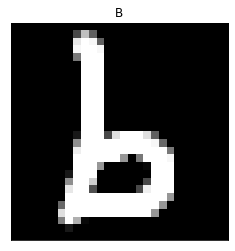

Predicted L and the original is B


In [9]:
from PIL import Image
IMAGE_NAME = 'b_1'

def convert_image_to_array(imageName):
    letter = imageName[0]
    image = Image.open('./images/{}.png'.format(imageName))
    data = np.asarray(image.convert('L'))
    image.close()
    data = np.array([np.insert(data, 0, ord(letter) - ord('a'))])
    return data

def predict_image(imageName):
    img_array = convert_image_to_array(imageName)
    plotSingleImg(img_array, imageName[0])
    
    original_letter = img_array[0][0]
    hot_encoded = model.predict(np.array([img_array[0][1:]]), verbose=0)
    print("Predicted {} and the original is {}".format(chr(np.argmax(hot_encoded, axis=1)[0] + ord('a')).upper(), imageName[0].upper()))

predict_image(IMAGE_NAME)

## Train Model

In [ ]:
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=1024,
                    epochs=100,
                    callbacks=[early_stopping, checkpoint]
                    )

# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()